In [1]:
import numpy as np

import matplotlib.pyplot as plt

import time

import timeit
from tqdm import tqdm

from scipy.stats import qmc


In [2]:
total_wfs=5

In [3]:
def generate_second_derivative_matrix(xgrid):
    N = len(xgrid)
    dx = xgrid[1]-xgrid[0]
    
    # Generate the matrix for the second derivative using a five-point stencil
    main_diag = np.ones(N) * (-5.0 /2 / dx**2)
    off_diag = np.ones(N - 1)* 4/3 / dx**2
    off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))
    
    D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)
    

    
    return D2


In [4]:
def harmonic_potential_matrix(xgrid):
    return np.diag(xgrid**2)


In [5]:
def self_interaction_potential(rho,alpha):
    return np.diag(rho**alpha)

In [6]:
def rho_maker(wf_list):
    sq_list=[wf**2 for wf in wf_list]
    return np.sum(sq_list, axis=0)

In [7]:
def list_normalizing(wf_list,dx):
    return [wf/np.linalg.norm(wf)*np.sign(wf_list[0][int(len(wf_list[0])/2)])*1/np.sqrt(dx) for wf in wf_list]

In [8]:
def H_solver(kappa,q,alpha,D2Mat,harmonic_matrix,rho,dx):
    
    H = -D2Mat + kappa*harmonic_matrix + q*self_interaction_potential(rho,alpha)
    evals,evects = np.linalg.eigh(H)
    
    
    
    return [evals[0:total_wfs],list_normalizing(evects.T[0:total_wfs],dx)]

In [9]:
#Example of a fixed grid

x_max = 15.0  # Maximum coordinate value for the grid

N_grid=300
# Set up the coordinate grid
x = np.linspace(-x_max, x_max, N_grid)
dx=x[1]-x[0]

D20=generate_second_derivative_matrix(x)
harmonic_matrix=harmonic_potential_matrix(x)

In [11]:
wf1=np.loadtxt("train_wf_list_1.txt")

In [18]:
U, S, Vt = np.linalg.svd(wf1.T, full_matrices=False)

In [17]:
wf1

array([[-3.17007295e-21,  1.19421244e-20,  3.51055754e-20, ...,
        -3.37843600e-20,  1.61701265e-19, -7.18074107e-20],
       [-2.27223364e-20, -6.23022084e-20, -1.36009644e-19, ...,
        -3.01747812e-18, -4.51851440e-18, -3.54903524e-18],
       [-1.80750234e-18, -3.57303461e-18, -4.76796250e-18, ...,
        -5.35027549e-19,  1.58278259e-18,  2.35068052e-18],
       ...,
       [ 7.51898998e-19,  1.49235156e-18,  2.00472090e-18, ...,
         3.49856508e-19, -1.15738258e-18, -1.13024465e-18],
       [-1.80292919e-19, -2.12207744e-19, -3.74491045e-20, ...,
         1.89602115e-19, -2.24461302e-19, -1.86261761e-19],
       [ 4.69762297e-20,  1.09068815e-19,  1.46778993e-19, ...,
        -7.04772436e-20, -9.73446914e-20, -9.21001927e-20]])

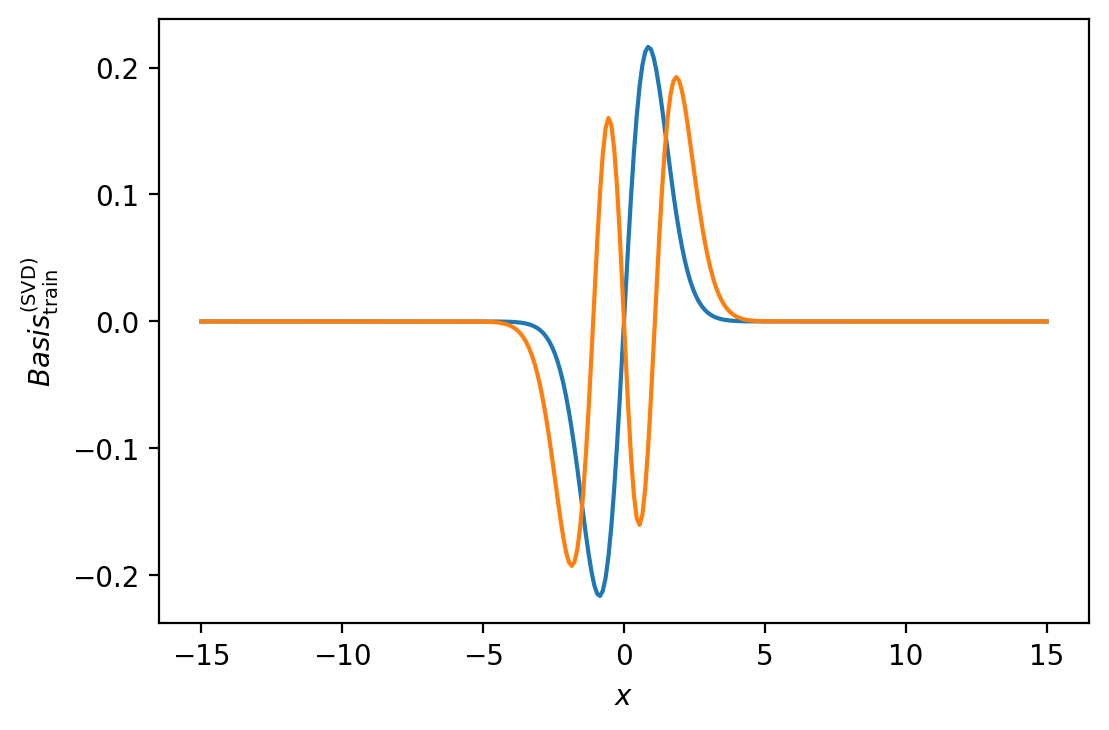

In [22]:
nbasis = 2

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for i in range(nbasis):
    ax.plot(x, U[:, i])

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$Basis_{\rm train}^{({\rm SVD})}$');

In [46]:
#Solving the system for kappa =1 , q=0, alpha=1 just to see how it looks without self interaction
Solutions0=H_solver(1,0,1,D20,harmonic_matrix,np.zeros(len(x)),dx)

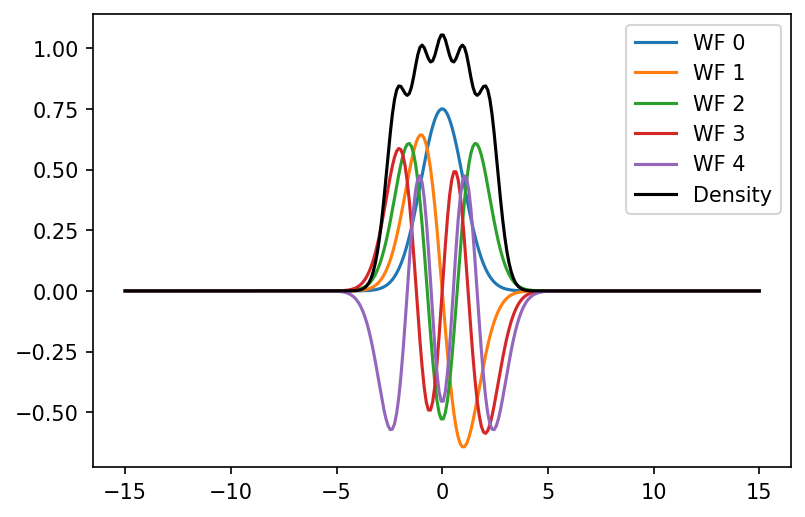

In [47]:
fig = plt.figure(dpi=150)

for i in range(len(Solutions0[1])):
    plt.plot(x,Solutions0[1][i],label=f'WF {i}')
    
plt.plot(x,rho_maker(Solutions0[1]),color='k',label='Density')
plt.legend()

plt.show()

In [48]:
#Variables controlling the iterative method
mixing_rate=0.15
max_iteration=500
tolerance=10**(-8)

In [49]:
def H_solver_iterative(kappa,q,alpha,D2Mat,harmonic_matrix,dx):
    
    Solution_current=H_solver(kappa,0,1,D20,harmonic_matrix,np.zeros(len(x)),dx)

    rho_current=rho_maker(Solution_current[1])
    rho_current=1/2*(rho_current+np.flip(rho_current))
    eigen_vals_current=Solution_current[0]
    
    for k in range(max_iteration):
        eigen_vals_old=np.copy(eigen_vals_current)
        
        
        Solution_current=H_solver(kappa,q,alpha,D20,harmonic_matrix,rho_current,dx)
        rho_current=rho_maker(Solution_current[1])*mixing_rate+rho_current*(1-mixing_rate)
        rho_current=1/2*(rho_current+np.flip(rho_current))
        
        eigen_vals_current=Solution_current[0]
        
        if (max(np.abs(eigen_vals_current-eigen_vals_old))<tolerance):
            break
    
    if k>=max_iteration-2:
        print("Max Iteration Reached")
#     print(k)
    return Solution_current
    
    

In [67]:
#Solving the system for kappa =1, q =50, alpha =5
Sol_iterat=H_solver_iterative(1,5,2,D20,harmonic_matrix,dx)
Sol_iterat2=H_solver_iterative(1,-5,2,D20,harmonic_matrix,dx)

Max Iteration Reached


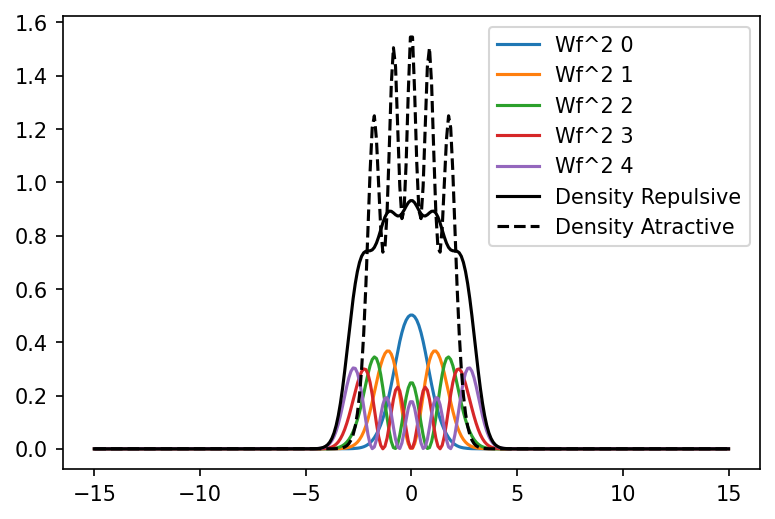

In [69]:
fig = plt.figure(dpi=150)

for i in range(len(Sol_iterat[1])):
    plt.plot(x,Sol_iterat[1][i]**2,label=f'Wf^2 {i}')
    
plt.plot(x,rho_maker(Sol_iterat[1]),color='k',label='Density Repulsive')

plt.plot(x,rho_maker(Sol_iterat2[1]),color='k',label='Density Atractive',linestyle='dashed')

plt.legend()

plt.show()

## Solving several high fidelity iterations

In [76]:
kappabounds=[0.5,3]
qbounds=-2,2
alpha0=[0.5,3]

bounds=np.array([
    kappabounds,
    qbounds,
    alpha0
    
    
])

In [86]:
n_train=300


sampler = qmc.LatinHypercube(d=len(bounds), seed=142857)

sample = sampler.random(n_train)
train = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

In [87]:
n_test=300


sampler = qmc.LatinHypercube(d=len(bounds), seed=1)

sample = sampler.random(n_test)
test = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

In [88]:
train_wf=[]
for params in tqdm(train):
    res=H_solver_iterative(params[0],params[1],params[2],D20,harmonic_matrix,dx)
    train_wf.append([params,res])






100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [06:00<00:00,  1.20s/it]


In [89]:
test_wf=[]
for params in tqdm(test):
    res=H_solver_iterative(params[0],params[1],params[2],D20,harmonic_matrix,dx)
    test_wf.append([params,res])

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [05:57<00:00,  1.19s/it]


In [173]:
train_wf_list=np.transpose(np.array([train_wf[i][1][1] for i in range(len(train_wf))]),axes=(1, 0, 2))

In [175]:
#This line is done to make all the wf have the same signs
for i in range(len(train_wf_list)):
    for k in range(len(train_wf_list[i])):
        train_wf_list[i][k]=train_wf_list[i][k]*np.sign(train_wf_list[i][k][int(len(train_wf_list[i][k])/2+1)])

In [156]:
train_evals_list=np.array([train_wf[i][1][0] for i in range(len(train_wf))])

In [149]:
test_wf_list=np.transpose(np.array([test_wf[i][1][1] for i in range(len(test_wf))]),axes=(1, 0, 2))

In [161]:
test_evals_list=np.array([test_wf[i][1][0] for i in range(len(test_wf))])

In [177]:
#This line is done to make all the wf have the same signs
for i in range(len(test_wf_list)):
    for k in range(len(test_wf_list[i])):
        test_wf_list[i][k]=test_wf_list[i][k]*np.sign(test_wf_list[i][k][int(len(test_wf_list[i][k])/2+1)])

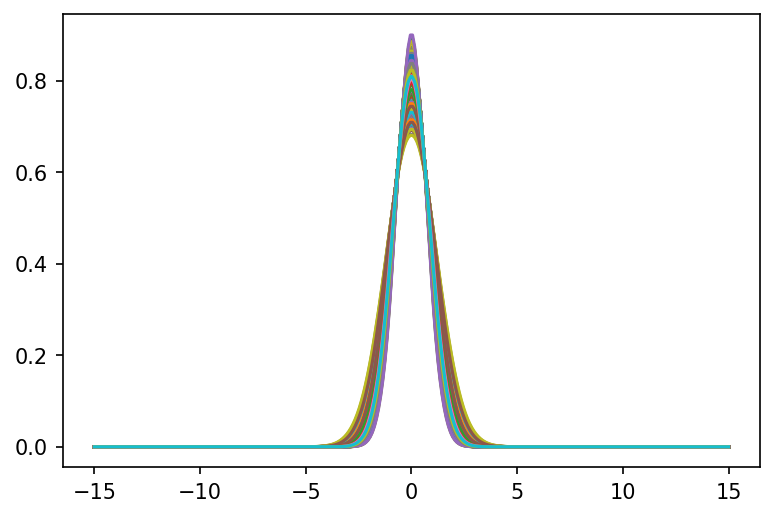

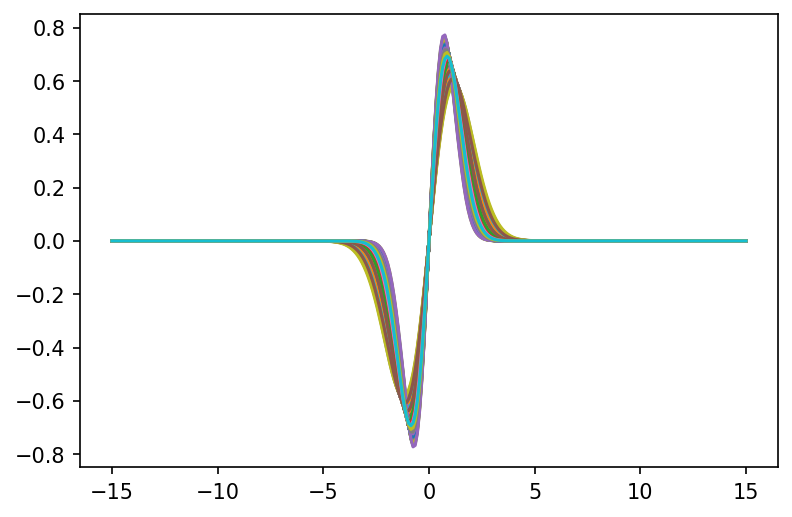

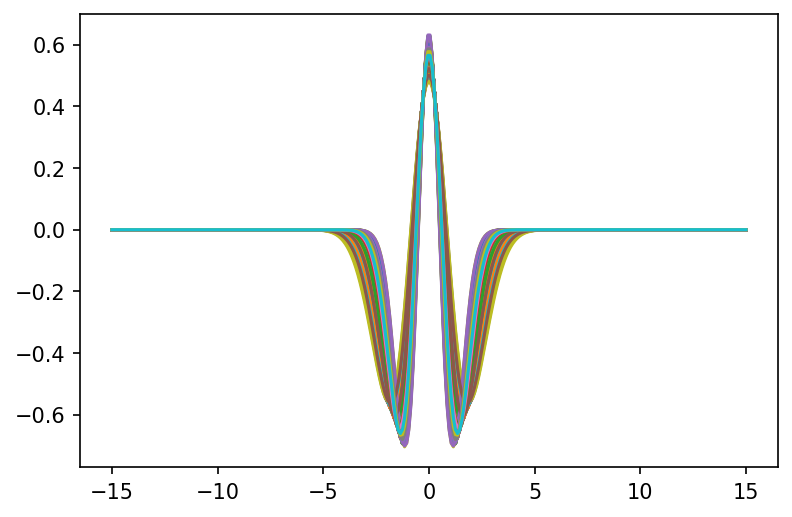

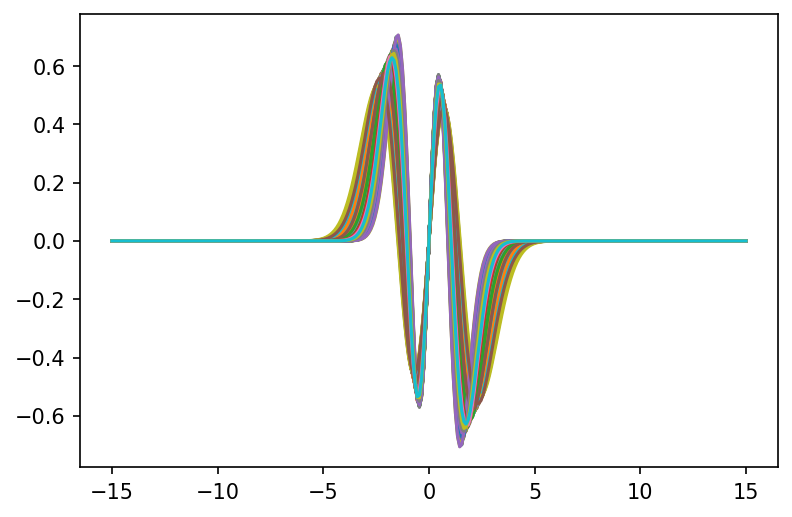

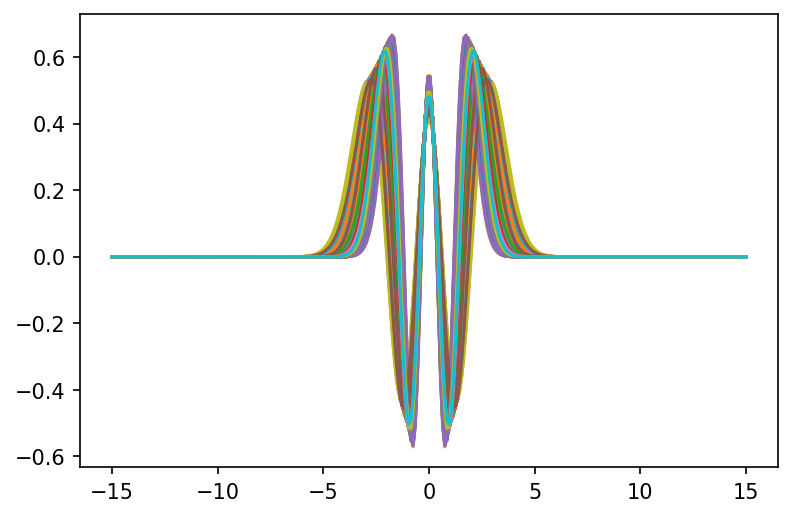

In [176]:
for k in range(len(train_wf_list)):
    fig = plt.figure(dpi=150)

    for i in range(len(train_wf_list[k])):
        plt.plot(x,train_wf_list[k][i])



    plt.show()

In [178]:
for i in range(len(test_wf_list)):
    np.savetxt("train_wf_list_{}.txt".format(i),train_wf_list[i])


In [179]:
for i in range(len(test_wf_list)):
    np.savetxt("test_wf_list{}.txt".format(i),test_wf_list[i])


In [155]:
np.savetxt("Training_Parameters.txt",train)
np.savetxt("Testing_Parameters.txt",test)

In [162]:
np.savetxt("train_evals_list.txt",train_evals_list)
np.savetxt("test_evals_list.txt",test_evals_list)